In [1]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator

import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

from tensorflow import keras
import tensorflow as tf

from petitRADTRANS.poor_mans_nonequ_chem import interpol_abundances
from petitRADTRANS import fort_input as fi
from petitRADTRANS import fort_rebin as fr
from petitRADTRANS import fort_spec as fs
from petitRADTRANS import nat_cst as nc
from exorad_opac import Radtrans
from petitRADTRANS.physics import guillot_global

import xgboost
from xgboost import XGBRegressor

%matplotlib widget

2023-04-28 13:19:06.857099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def t_x(X):
    # return transform_x_convolve(X)
    # return transform_x_outer_add(transform_x_scaled(X), reshape=False, log=True)
    # return diff(transform_x_scaled(X), do_log=False)
    # return np.log(X)
    return transform_x_sum(X, do_log=True)
    # return transform_x_scaled(X)
    # return transform_x_outer_add(X, log=True, reshape=True)
    # return transform_x_divide(X)
    # return diff(X, do_log=True)
    # return transform_x_diff_log(X, do_log=False)

def t_y(X, y):
    # return transform_y_scaled(X,y)
    # return diff(transform_y_scaled(X,y),do_log=False)
    return transform_y_sum(X, y, do_log=True)
    # return np.log(y)
    # return transform_y_divide_sum(X, y)
    # return diff(y, do_log=True)
    # return transform_y_diff_log_sum(X, y, do_log=False)

def ti_y(X, y):
    # return np.exp(y)
    # return inverse_transform_y_scaled(X,integrate_diff(y, do_log=False))
    return inverse_transform_y_sum(X, y, do_log=True)
    # return inverse_transform_y_scaled(X,y)
    # return np.exp(y)
    # return inverse_transform_y_divide_sum(X, y)
    # return integrate_diff(y, do_log=True)
    # return inverse_transform_y_diff_log_sum(X, y, do_log=False)



In [5]:
mlp_weights = [np.load('mlp_deep_set_0.npy'),np.load('mlp_deep_set_1.npy')]

def simple_deep_set(kappas):
    rep = np.tensordot(kappas, mlp_weights[0], axes=(1,0))  # first dense
    rep[rep < 0.0] = 0.0
    sum_rep = np.sum(rep, axis=1)   # sum
    dec = np.tensordot(sum_rep, mlp_weights[1], axes=(-1,0))  # second dense
    return dec

def mix_kappa_deep_set(kappas):
    shape_pred = (kappas.shape[1]*kappas.shape[3],kappas.shape[0], kappas.shape[2])
    shape = kappas.shape[0], kappas.shape[1], kappas.shape[-1]
    kappas_resh = kappas.transpose(1,3,0,2).reshape(shape_pred)
    kout = ti_y(kappas_resh, simple_deep_set(t_x(kappas_resh))).T.reshape(shape)
    return kout

def mix_kappa_add(kappas):
    return np.sum(kappas, axis=2)


def mix_kappa(kappas):
    # return mix_kappa_add(kappas)
    return mix_kappa_deep_set(kappas)


class TimingRadtrans(Radtrans):
    def mix_opa_tot(self, *args, **kwargs):
        t = time.time()
        self.mix_opa_tot_custom(*args, **kwargs)
        self.time_opa = time.time() - t

    def mix_opa_tot_custom(self, *args, **kwargs):
        return super().mix_opa_tot(*args, **kwargs)

class FakeRadtrans(TimingRadtrans):
    def mix_opa_tot_custom(self, abundances, mmw, gravity,
                    sigma_lnorm=None, fsed=None, Kzz=None,
                    radius=None,
                    add_cloud_scat_as_abs=None,
                    dist="lognormal", a_hans=None,
                    b_hans=None,
                    give_absorption_opacity=None,
                    give_scattering_opacity=None):
        # Combine total line opacities,
        # according to mass fractions (abundances),
        # also add continuum opacities, i.e. clouds, CIA...
        self.mmw = mmw
        self.scat = False

        for i_spec in range(len(self.line_species)):
            self.line_abundances[:, i_spec] = abundances[self.line_species[i_spec]]

        self.continuum_opa = np.zeros_like(self.continuum_opa)
        self.continuum_opa_scat = np.zeros_like(self.continuum_opa_scat)
        self.continuum_opa_scat_emis = np.zeros_like(self.continuum_opa_scat_emis)

        # Calc. CIA opacity
        for key in self.CIA_species.keys():
            abund = 1

            for m in self.CIA_species[key]['molecules']:
                abund = abund * abundances[m]

            self.continuum_opa = self.continuum_opa + \
                self.interpolate_cia(key, np.sqrt(abund))

        # Calc. H- opacity
        if self.Hminus:
            self.continuum_opa = \
                self.continuum_opa + pyi.hminus_opacity(self.lambda_angstroem,
                                                        self.border_lambda_angstroem,
                                                        self.temp, self.press, mmw, abundances)

        # Add mock gray cloud opacity here
        if self.gray_opacity is not None:
            self.continuum_opa = self.continuum_opa + self.gray_opacity

        # Add cloud opacity here, will modify self.continuum_opa
        if self._check_cloud_effect(abundances):  # add cloud opacity only if there is actually clouds
            self.scat = True
            self.calc_cloud_opacity(abundances, mmw, gravity,
                                    sigma_lnorm, fsed, Kzz, radius,
                                    add_cloud_scat_as_abs,
                                    dist=dist, a_hans=a_hans, b_hans=b_hans)

        # Calculate rayleigh scattering opacities
        if len(self.rayleigh_species) != 0:
            self.scat = True
            self.add_rayleigh(abundances)
        # Add gray cloud deck
        if self.Pcloud is not None:
            self.continuum_opa[:, self.press > self.Pcloud * 1e6] += 1e99
        # Add power law opacity
        if self.kappa_zero is not None:
            self.scat = True
            wlen_micron = nc.c / self.freq / 1e-4
            scattering_add = self.kappa_zero \
                * (wlen_micron / 0.35) ** self.gamma_scat
            add_term = np.repeat(scattering_add[None],
                                 int(len(self.press)), axis=0).transpose()
            self.continuum_opa_scat += add_term

            if self.do_scat_emis:
                self.continuum_opa_scat_emis += add_term

        # Check if hack_cloud_photospheric_tau is used with
        # a single cloud model. Combining cloud opacities
        # from different models is currently not supported
        # with the hack_cloud_photospheric_tau parameter
        if len(self.cloud_species) > 0 and self.hack_cloud_photospheric_tau is not None:
            if give_absorption_opacity is not None or give_scattering_opacity is not None:
                raise ValueError("The hack_cloud_photospheric_tau can only be "
                                 "used in combination with a single cloud model. "
                                 "Either use a physical cloud model by choosing "
                                 "cloud_species or use parametrized cloud "
                                 "opacities with the give_absorption_opacity "
                                 "and give_scattering_opacity parameters.")

        # Add optional absorption opacity from outside
        if give_absorption_opacity is None:
            if self.hack_cloud_photospheric_tau is not None:
                if not hasattr(self, "hack_cloud_total_abs"):
                    opa_shape = (self.freq.shape[0], self.press.shape[0])
                    self.hack_cloud_total_abs = np.zeros(opa_shape)

        else:
            cloud_abs = give_absorption_opacity(nc.c/self.freq/1e-4, self.press*1e-6)
            self.continuum_opa += cloud_abs

            if self.hack_cloud_photospheric_tau is not None:
                # This assumes a single cloud model that is
                # given by the parametrized opacities from
                # give_absorption_opacity and give_scattering_opacity
                self.hack_cloud_total_abs = cloud_abs

        # Add optional scatting opacity from outside
        if give_scattering_opacity is None:
            if self.hack_cloud_photospheric_tau is not None:
                if not hasattr(self, "hack_cloud_total_scat_aniso"):
                    opa_shape = (self.freq.shape[0], self.press.shape[0])
                    self.hack_cloud_total_scat_aniso = np.zeros(opa_shape)

        else:
            cloud_scat = give_scattering_opacity(nc.c/self.freq/1e-4, self.press*1e-6)
            self.continuum_opa_scat += cloud_scat

            if self.do_scat_emis:
                self.continuum_opa_scat_emis += cloud_scat

            if self.hack_cloud_photospheric_tau is not None:
                # This assumes a single cloud model that is
                # given by the parametrized opacities from
                # give_absorption_opacity and give_scattering_opacity
                self.hack_cloud_total_scat_aniso = cloud_scat

        # Interpolate line opacities, combine with continuum oacities
        self.line_struc_kappas = fi.mix_opas_ck(self.line_abundances,
                                                self.line_struc_kappas, self.continuum_opa)

        # Similar to the line-by-line case below, if test_ck_shuffle_comp is
        # True, we will put the total opacity into the first species slot and
        # then carry the remaining radiative transfer steps only over that 0
        # index.
        if (self.mode == 'c-k') and self.test_ck_shuffle_comp:
            self.line_struc_kappas[:, :, 0, :] = mix_kappa(self.line_struc_kappas)

        # In the line-by-line case we can simply
        # add the opacities of different species
        # in frequency space. All opacities are
        # stored in the first species index slot
        if (self.mode == 'lbl') and (int(len(self.line_species)) > 1):
            self.line_struc_kappas[:, :, 0, :] = \
                np.sum(self.line_struc_kappas, axis=2)

In [6]:
R='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))

load = False
load_model = False

opac = ReadOpacChubb(files)
opac.read_opac()

In [7]:
pressures = np.logspace(-6, 2, 10)
# pressures = chubb.pr
linespecies = [f.split('/')[-1].split('.')[0] for f in files]
tgrid=np.logspace(2,4,1000)
atmosphere_orig = TimingRadtrans(tgrid=tgrid,line_species=linespecies, pressures=pressures, wlen_bords_micron=[(1e4/opac.bin_edges).min(), (1e4/opac.bin_edges).max()])
atmosphere = FakeRadtrans(tgrid=tgrid,line_species=linespecies, pressures=pressures, wlen_bords_micron=[(1e4/opac.bin_edges).min(), (1e4/opac.bin_edges).max()])


/Users/schneider/anaconda3/envs/ml/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of NH3_R_S1...
 Done.
  Read line opacities of CO_all_iso_Chubb_R_S1...
 Done.
  Read line opacities of TiO_all_Exomol_R_S1...
 Done.
  Read line opacities of H2O_Exomol_R_S1...
 Done.
  Read line opacities of PH3_R_S1...
 Done.
  Read line opacities of VO_R_S1...
 Done.
  Read line opacities of HCN_R_S1...
 Done.
  Read line opacities of Na_allard_R_S1...
 Done.
  Read line opacities of FeH_R_S1...
 Done.
  Read line opacities of SiO_R_S1...
 Done.
  Read line opacities of K_allard_R_S1...
 Done.
  Read line opacities of CO2_R_S1...
 Done.
  Read line opacities of H2S_R_S1...
 Done.
  Read line opacities of CH4_R_S1...
 Done.

  Read line opacities of NH3_R_S1...
 Done.
  Read line opacities of CO_all_iso_Chubb_R_S1...
 Done.
  Read line opacities of TiO_all_Exomol_R_S1...
 Done.
  Read line opacities of H2O_Exomol_R_S1...
 Done.
  Read line opacities of PH3_R_S1...
 Done.
  Read line opacities of VO_R_S1...
 Done.
  Read line opacities of HCN_R_S1...
 Done.
  Re

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

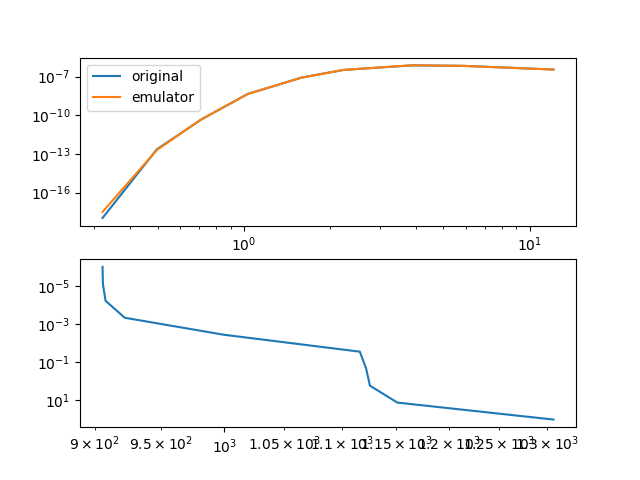

In [8]:
fig_fl, ax_fl = plt.subplots(2,1)

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_flux_toa(gamma, T_int, T_equ):
    for axi in ax_fl:
        axi.cla()
    
    kappa_IR = 0.05      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])            
    
    atmosphere_orig.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
    atmosphere.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)

    print('orig, fake, speedup',atmosphere_orig.time_opa, atmosphere.time_opa, atmosphere_orig.time_opa/atmosphere.time_opa)

    bol_orig =np.sum(atmosphere_orig.flux*np.diff(atmosphere_orig.border_freqs))
    bol = np.sum(atmosphere.flux*np.diff(atmosphere.border_freqs))
    print('error:', (bol_orig-bol)/bol)

    ax_fl[0].plot(nc.c/atmosphere_orig.freq*1e4, atmosphere_orig.flux, label ='original')
    ax_fl[0].plot(nc.c/atmosphere.freq*1e4, atmosphere.flux, label ='emulator')
    ax_fl[0].set_xscale('log')
    ax_fl[0].set_yscale('log')
    ax_fl[1].loglog(temperature, pressures)
    ax_fl[1].invert_yaxis()
    ax_fl[0].legend()
    

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

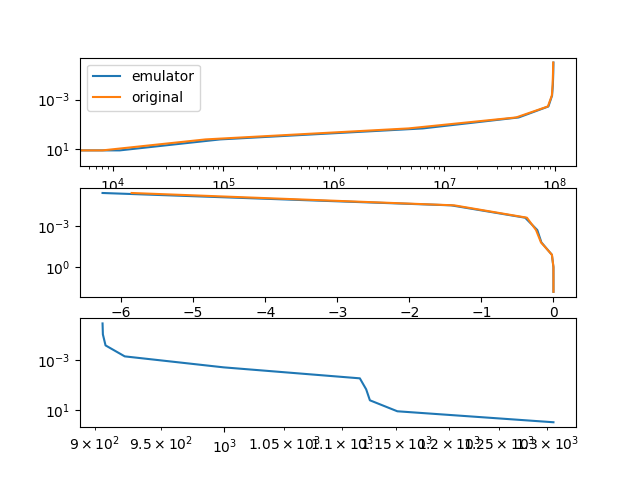

In [9]:
fig_flb, ax_flb = plt.subplots(3,1)

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_flux_bol(gamma, T_int, T_equ):
    for axi in ax_flb:
        axi.cla()
    
    kappa_IR = 0.05      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])            
    
    t0 = time.time()
    atmosphere_orig.calc_bolometric_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
    t1 = time.time()
    atmosphere.calc_bolometric_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
    t2 = time.time()
    print('orig, fake, speedup',t1-t0,t2-t1, (t1-t0)/(t2-t1))

    bol_orig =atmosphere_orig.flux_bol
    bol = atmosphere.flux_bol
    # print('error:', (bol_orig-bol)/bol)

    p_e = atmosphere.press/1e6
    p_c = .5*(p_e[1:]+p_e[:-1])

    ax_flb[0].plot(atmosphere.flux_bol, p_e, label ='emulator')
    ax_flb[0].plot(atmosphere_orig.flux_bol, p_e, label ='original')
    ax_flb[1].plot(np.diff(atmosphere.flux_bol)/np.diff(p_e), p_c, label ='emulator')
    ax_flb[1].plot(np.diff(atmosphere_orig.flux_bol)/np.diff(p_e), p_c, label ='original')
    ax_flb[2].loglog(temperature, pressures)
    ax_flb[1].set_yscale('log')
    ax_flb[0].set_yscale('log')
    ax_flb[0].set_xscale('log')
    # ax_fl[1].set_xscale('log')
    ax_flb[1].invert_yaxis()
    ax_flb[2].invert_yaxis()
    ax_flb[0].invert_yaxis()
    ax_flb[0].legend()
    

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

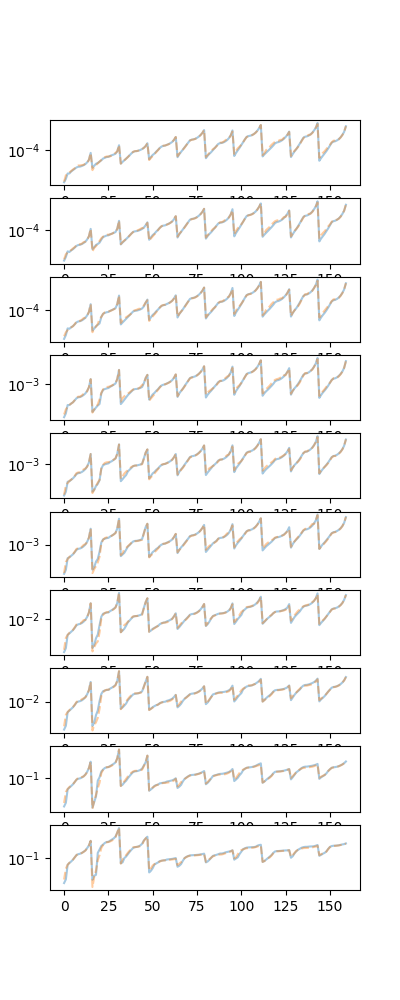

In [10]:
fig_kappa, ax_kappa = plt.subplots(10,1, figsize = (4,10))

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_eq_chem(gamma, T_int, T_equ):
    for axi in ax_kappa:
        axi.cla()  
    
    kappa_IR = 0.05      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])   

    x_predict = np.empty((len(atmosphere.press),opac.ls+2))

    spec_names = {sp.split('_')[0]: sp for sp in atmosphere.line_species}

    for i, spec in enumerate(opac.spec):
        x_predict[:,i] = mass_fractions[spec_names[spec]]

    x_predict[:, -2] = atmosphere.press/1e6
    x_predict[:, -1] = temperature

    atmosphere.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
    line_struc_kappas_fake = atmosphere.line_struc_kappas[:,:,0,:]

    atmosphere_orig.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
    line_struc_kappas_orig = atmosphere_orig.line_struc_kappas[:,:,0,:]
    
    for i, p in enumerate(atmosphere.press):
        ax_kappa[i].plot(line_struc_kappas_fake[:,:,i].T.flatten(), ls = '-', alpha=0.4)
        ax_kappa[i].plot(line_struc_kappas_orig[:,:,i].T.flatten(), ls = '--', alpha=0.4)
    
        ax_kappa[i].set_yscale('log')
    


    